# Exploration of Pennsylvania's Montgomery County                          Emergency Calls
___
## *By Jose Vargas*

This project will use [this](https://www.kaggle.com/mchirico/montcoalert) publicly available data. The data set contains information on emergency calls in Pennsylvania's Montgomery County. Due to the observational nature of the data, this project will focus on visualizations to discover any trends or points of interest within the data set. Let's begin!

### Setup
___

I first need to import Python's analytical and visualization modules.

In [45]:
# Standard library modules
import itertools as it

# Data analysis modules
from scipy import stats
import numpy as np
import pandas as pd

# Data visualization modules
from matplotlib import dates as dt, pyplot as plt
import seaborn as sns

# IPython magics
%matplotlib inline

Now I will read in the data.

In [46]:
df = pd.read_csv('911.csv')

### Initial Data Exploration
___

Wonder what we have to work with...

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 9 columns):
lat          99492 non-null float64
lng          99492 non-null float64
desc         99492 non-null object
zip          86637 non-null float64
title        99492 non-null object
timeStamp    99492 non-null object
twp          99449 non-null object
addr         98973 non-null object
e            99492 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 4.9+ MB


In [48]:
df.head(3)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1


In [49]:
df.tail(3)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
99489,40.115429,-75.334679,CHESTNUT ST & WALNUT ST; NORRISTOWN; Station ...,19401.0,EMS: FALL VICTIM,2016-08-24 11:12:00,NORRISTOWN,CHESTNUT ST & WALNUT ST,1
99490,40.186431,-75.192555,WELSH RD & WEBSTER LN; HORSHAM; Station 352; ...,19002.0,EMS: NAUSEA/VOMITING,2016-08-24 11:17:01,HORSHAM,WELSH RD & WEBSTER LN,1
99491,40.207055,-75.317952,MORRIS RD & S BROAD ST; UPPER GWYNEDD; 2016-08...,19446.0,Traffic: VEHICLE ACCIDENT -,2016-08-24 11:17:02,UPPER GWYNEDD,MORRIS RD & S BROAD ST,1


The first two columns, ***'lat'*** and ***'lng'***, contain the latitude and longitude of the call. I will change the title of these columns so that it is explicitly clear what each of these two columns represent. The third column, ***'desc'***, seems to contain information that can be more easily accessed through other columns, such as the address and township.

The ***'title'*** column seems to be composed of two different sections; the specific department (EMS, Fire, or Traffic) and the reason that department was called. We can definitely use this information. When the 'Traffic' department is called, the reason has an unnecessary hypen at the end. I'll remove that in the next section.

The ***'timeStamp'*** column has both the date and time of day that the call occured. We can use this data, combined with the ***'title'*** column,  to identify temporal trends in emergency calls. The data set begins on December 10, 2015 and ends on August 24, 2016. I'll keep this in mind when creating graphs. I will also need to change the data type of this column to a datetime object, as all the temporal functionality necessitates that object type.

The ***'twp'*** column contains the name of the township where the emergency occured. Township names are more meaningful than simple zip codes. We can explore any relationships between townships and the reasons that residents contact 911 by combining this data with the informatino in the ***'title'*** and ***'timeStamp'*** columns.

The penultimate column, ***'addr'*** contains the address of the incident. This data is likely quite granular and therefore unsuitable to obtain trends given the limited data available. 

### Data Cleaning and Manipulation
___

I'll begin by renaming the ***lat*** and ***lng*** columns. 

In [50]:
df.rename(columns={'lat': 'Latitude', 'lng': 'Longitude'}, inplace=True)

I'll go ahead and create a ***'Department'*** and ***'Reason'*** column from the ***'title'*** column.

In [51]:
# Split the 'title' column.
lambda_func = lambda x: list(map(str.strip, x.split(':')))
df['Department'], df['Reason'] = zip(*df['title'].apply(lambda_func))

# Remove hyphen from traffic call reason.
loc_logic = df['Department']=='Traffic','Reason' 
df.loc[loc_logic] = df.loc[loc_logic].apply(lambda x: x[:-2])

From the ***'timeStamp'*** column we can extract quite a few data points. Lets obtain the ***hour***, ***day of the week***, ***day of the month***, and the ***date*** as separate columns. I'll begin by changing the data type.

In [52]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

Ok. Now we can extract the hour and the day of the week and month.

In [53]:
# Specify new column names.
newCols = ['Hour', 'Day of Week', 'Day of Month', 'Date']

# Specify the respective lambda functions.
funcs = [lambda x: x.hour, lambda x: x.dayofweek, lambda x: x.day,
         lambda x: x.date()]

# Create the new columns by looping through the 'newCols' and 'funcs' lists.
for col, func in zip(newCols, funcs):
    df[col] = df['timeStamp'].apply(func)

Alright. I'll go ahead and check that the dataset contains everything that I need.

In [54]:
df.head(1)

,Latitude,Longitude,desc,zip,title,timeStamp,twp,addr,e,Department,Reason,Hour,Day of Week,Day of Month,Date
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1,EMS,BACK PAINS/INJURY,17,3,10,2015-12-10


Everything looks good so far! 

I'll now create **box plots** for both the latitude and longitude columns to **identify geographically anomalous data**.

In [55]:
def format_tick_fontsize(ax, tickfont=14):

    # This method sets the x and y ticks to equal fontsize (tickfont) 
    # given axes (ax).
    #
    # ----------- variables --------------
    # ax: matplotlib axes instance
    # tickfont: fontsize for tick marks
    
    # Increase x-axis tick fontsize.
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(tickfont)

    # Increase y-axis tick fontsize.
    for label in ax.yaxis.get_ticklabels():
        label.set_fontsize(tickfont)

In [56]:
def format_labels(ax, xlabel='', ylabel='', xpad=10, ypad=10,
                  xrot='horizontal', yrot='vertical',  **kwargs):
    
    # This method formats the x and y labels.
    #
    # -------  x-axis variables ----- 
    # xlabel: User specified text for label
    # xpad: Label padding
    # xrot: Label rotationpositioned
    #
    # -------  y-axis variables ------ 
    # ylabel: User specified text for label
    # ypad: Label padding
    # yrot: Label rotationpositioned
    
    # If user doesn't provide custom label, obtain labels from axes object. 
    if not xlabel:
        xlabel = ax.get_xlabel()
    if not ylabel:
        ylabel = ax.get_ylabel()
        
    # Format each label
    ax.set_xlabel(xlabel, labelpad=xpad, rotation=xrot, **kwargs)
    ax.set_ylabel(ylabel, labelpad=ypad, rotation=yrot, **kwargs)

In [57]:
def boxplots(df, x, columns, palette='viridis', tickfont=10):
    
    # This method creates a specified number of boxplots.
    #
    # ----------- variables --------------
    # df: Pandas dataframe
    # x: Categorical column in df
    # columns: Columns in df whose distribution will be calculated.
    #          Length determines number of subplots.
    # palette: Sets color palette for box plots.
    # tickfont: Tick font size to be used on both x and y axes.
    
    # Create figure and axes instances.
    fig, axs = plt.subplots(ncols=len(columns))
    
    # Create boxplots.
    for ax, col in zip(axs, columns):
        sns.boxplot(x=x, y=col, data=df, ax=ax, palette=palette)
        
        # Set and format title, labels and tick marks.
        ax.set_title("Calls' {} Distrition".format(col), weight='bold',
                    fontsize=12, y=1.05)
        format_tick_fontsize(ax, tickfont)
        format_labels(ax, fontsize=12, weight='bold')
    
    # Adjust whitespace between column subplots.
    fig.subplots_adjust(wspace=1)

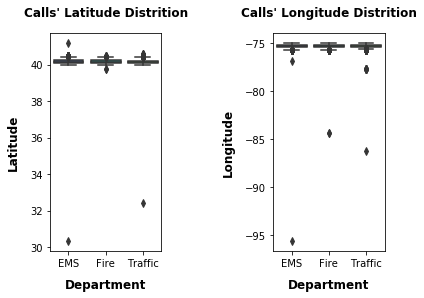

In [58]:
boxplots(df, 'Department', ['Latitude', 'Longitude'])

There definitely are geographical outliers. **Montgomery County's minimum and maximum latitude and longitide are**, respectively, **(39.977003, 40.447839) and 
(-75.696521, -75.015070)**. Furthermore, the Montgomery County is surrounded by the counties of *Philadelphia, Lehigh, Delaware, Chester, Bucks, and Berks*. 

The county has [several](http://webapp02.montcopa.org/mycommunity/poi/MapMontcoEMSSquads_cp.htm) medical squads in these neighboring counties. As such, if a particular data entry has latitude or longitude coordinates outside of those of Montgomery County, but their entry for the *'twp'* column is one of Montgomery County's neighbor counties, the datum will not be deleted. 

In [59]:
# Determine outlier indeces.
query_outliers = (((~df['Latitude'].between(39.977003, 40.447839))
                  | (~df['Longitude'].between(-75.696521, -75.015070)))
                  & (~df['twp'].apply(lambda x: 'COUNTY' in str(x))))
outlier_indeces = df[query_outliers].index

# Drop outlier indeces
df.drop(outlier_indeces, axis='rows', inplace=True)

Let's verify that the extreme outliers have been removed.

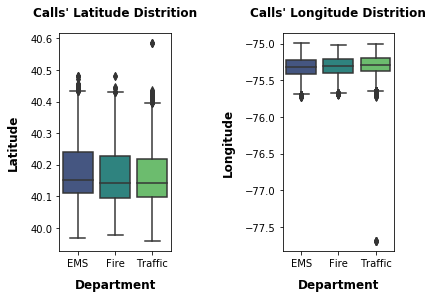

In [60]:
boxplots(df, 'Department', ['Latitude', 'Longitude'])

The latitude plot seems much more reasonable. There are still some entries whose longitude is suspiciously to the east. Let's investigate this further.

In [61]:
lng_outliers = df[df['Longitude'] <-77.5][['Latitude','Longitude', 'twp']]
lng_outliers

,Latitude,Longitude,twp
13757,40.160004,-77.686813,BERKS COUNTY
17829,40.160004,-77.686813,BERKS COUNTY
18843,40.160004,-77.686813,BERKS COUNTY
19865,40.160004,-77.686813,BERKS COUNTY
31512,40.160004,-77.686813,BERKS COUNTY
63377,40.160004,-77.686813,BERKS COUNTY
64260,40.160004,-77.686813,BERKS COUNTY
76354,40.160004,-77.686813,BERKS COUNTY


A quick Google search [places](https://www.google.com/maps/place/40%C2%B009'36.0%22N+77%C2%B041'12.5%22W/@40.2217594,-76.379179,8.75z/data=!4m5!3m4!1s0x0:0x0!8m2!3d40.16!4d-77.6868) these coordinates to the east of Harrisburg, PA. There must have been a data entry error. I'll go ahead and remove them.

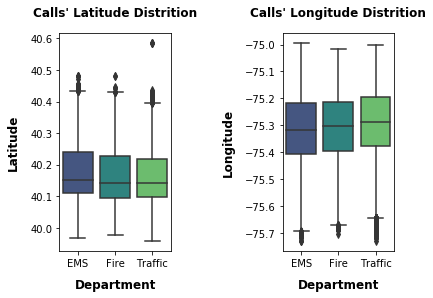

In [62]:
df.drop(lng_outliers.index, axis='rows', inplace=True)
boxplots(df, 'Department', ['Latitude', 'Longitude'])

The geographical distribution of the emergency calls appears to be much more reasonable.<br>
So far, I have:
1. Renamed *'lat'* and *'lng'* columns to 'Latitude' and 'Longitude', respectively.
2. Used the *'title'* column to generate two additional columns.
>    -  'Department' contains the name of the contacted department.
>    -  'Reasons' contains the the specifc emergency event of that call.
3. Altered the data type of the *'timeStamp'* column to a datetime object.
4. Manipulated the *'timeStamp'* column to obtain the following information.
>    -  Hour
>    -  Day of Week (Monday, Tuesday, etc.)
>    -  Day of Month
>    -  Date
5. Gotten rid of extreme geographical outliers in the data set. 

### Data Exploration and Visualization
___

I'll first examine which department received the most calls over the documented time period. This will require a couple of methods to format the bar plots.



In [63]:
def label_bar_v(ax, labels, col_lblfont=14, col_lblpad=2000):

    # This method adds labels to the top of columns in vertical bar plots.
    #
    # ----------- variables --------------
    # ax: matplotlib axes instance
    # labels: list of labels to be placed on top of the columns.
    # col_lblfont: Font size for the labels
    # col_lblpad: Padding for column labels. 

    # Obtain a list of each column object.
    rects = ax.patches

    # Attach labels to each column.
    for rect, label in zip(rects, labels):
        ha = 'center'
        color = 'black'

        # Determine position of each label.
        y_loc = rect.get_height() + col_lblpad
        x_loc = rect.get_x() + rect.get_width()/2

        # Set labels.
        label = ax.text(x_loc, y_loc, label, horizontalalignment=ha, 
                        verticalalignment='center', color=color, clip_on=True,
                        fontsize=col_lblfont)

In [64]:
def label_bar_h(ax, labels, col_lblfont=10, col_lblpad=10):

    # This method adds labels to the right of columns in horizontal bar plots.
    #
    # ----------- variables --------------
    # ax: matplotlib axes instance
    # labels: list of labels to be placed on to the right of the columns.
    # col_lblfont: Font size for the labels
    # col_lblpad: Padding for column labels. 

    # Obtain a list of each column object.
    rects = ax.patches

    # Attach labels to each column.
    for rect, label in zip(rects, labels):
        ha = 'left'
        color = 'black'

        # Determine position of each label.
        x_loc = rect.get_width() + col_lblpad
        y_loc = rect.get_y() + rect.get_height()/2

        # Set labels.
        label = ax.text(x_loc, y_loc, label, horizontalalignment=ha, 
                        verticalalignment='center', color=color, clip_on=True,
                        fontsize=col_lblfont)

def format_bar_h(ax, dept_name, dept_dicts, titlefont=14, y=1.02,
                 tickfont= 10, col_lblfont=10, col_lblpad=10, xaxispad=2500, 
                 title=''):

    # This method formats horizontal bar plots. The label_bar_h method is run 
    # as a sub routine to append column labels to the bars.
    #
    # ----------- variables --------------
    # ax: Matplotlib axes instance
    # dept_name: Name of department whose info is plotted.for a given department
    # dept_dicts: Dictionary composed of department names as keys and the 
    #             reasons the department was called, in decreasing frequency, as 
    #             values. The values are pandas Series objects.
    # titlefont: Fontsize for the graph's title.
    # tickfont: Fontsize for tick labels.
    # col_lblfont: Fontsize for column labels. Passed to subroutine.
    # col_lblpad: Padding for the horizontal labels. Passed to subroutine. 
    # y: Adjusts position of title text.
    # lblfont: Fontsize for the axes labels.
    # xaxispad: Added to the maximum x axis coordinate to ensure column labels
    #           are not cut off. 

    # Obtain the number of occasions the department was called for each reason.
    # These will be the column labels.
    labels = [str(num) for num in list(dept_dicts[dept_name])]

    # Call sub routine to append labels to columns.
    label_bar_h(ax, labels, col_lblfont, col_lblpad)

    # Adjust the x-axis to fit the data. 
    xmax = dept_dicts[dept_name].max()
    ax.set_xlim(0,xmax+xaxispad)

    # Reverse the y axis to have the reasons plotted in increasing frequency.
    ax.set_ylim(ax.get_ylim()[::-1])

    # Set graph title.
    ax.set_title("{0} {1} - Montgomery County, PA".format(dept_name, title), 
                 loc='left', fontsize=titlefont, weight='bold', y=y)

    # Turn off all spines except the left spine.
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.tick_params(
        labelbottom='off',
        bottom='off')
    
    # Format tick fontsize.
    format_tick_fontsize(ax, tickfont)

Alright. Now we can begin to visualize the data.

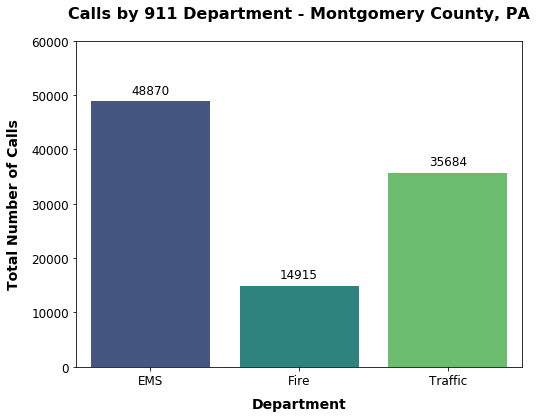

In [65]:
# Create figure and axes.
fig, ax = plt.subplots(figsize=(8,6))

# Create a countplot.
sns.countplot(x='Department', data=df, palette = 'viridis', ax=ax)

# Format figure title and axes.
title = ax.set_title('Calls by 911 Department - Montgomery County, PA',
                     fontsize=16, weight='bold', y=1.05)
ylim = ax.set_ylim(0,60000)
format_labels(ax, ylabel='Total Number of Calls', fontsize=14, weight='bold')

# Adjust tick fontsize and label the bar columns
format_tick_fontsize(ax, tickfont=12)
labels = [str(num) for num in list(df.groupby('Department').count()['e'])]
label_bar_v(ax, labels, col_lblfont=12)

From this graph, we note that the **EMS is the most frequently called department**, followed by the Traffic and Fire departments. Almost half of Montgomery County residents who called 911 were in need of acute medical care. Let's **explore** the **number of calls by each department by day** and the **reasons why each department was called**. 

In [66]:
# Having the three department names in a list will facilitate the upcoming 
# visualizations.
depts = ['EMS', 'Fire', 'Traffic']

# These are the respective colors of each department in the previous graphs. 
colors = {'EMS':'#455681', 'Fire':'#2F837F', 'Traffic': '#6CBC6E'}

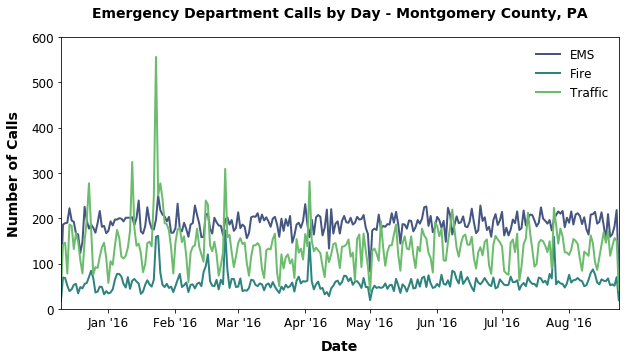

In [67]:
# Create figure and axes instances. 
fig, ax = plt.subplots(figsize=(10,5))

# Calculate the number of calls each department received by day.
dept_calls_by_date = (df.groupby(['Date', 'Department']).count()['e'].
                      unstack(level=-1))

# Plot each dataframe column. 
for dept in depts:
    dept_calls_by_date[dept].plot(ax=ax, c=colors[dept], linewidth=2,
                                  legend=True)

# Format axes.
dateFmt = dt.DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(dateFmt);
ax.set_title('Emergency Department Calls by Day - Montgomery County, PA',
            fontsize=14, weight='bold', y=1.05)
ax.legend(frameon=False, fontsize=12);
ax.set_ylim(0,600);
format_tick_fontsize(ax, tickfont=12)
format_labels(ax, ylabel='Number of Calls', fontsize=14, weight='bold')

The bar plot indicated that the most frequently contacted  emergency department was the Emergency Medical Service. Therefore, it was expected that the EMS would have the largest call volume by day. This is true... *most days*. There are several instances where traffic emergency calls surge dramatically. The large influx of traffic calls toward the latter half of January 2016 is particularly remarkable.

Harder to notice is the similarity in behavior between traffic and fire department emergency calls. Peaks and valleys in traffic call volume seem to coincide with how often the fire department is called.

This graph presents two opportunities for further exploration:
> * The event(s) in the latter half of January 2016, if any, that help explain the large increase in traffic emergency calls.
> * The relationship between traffic and fire department calls. 

Let's compare the relationship in call frequency between all three emergency departments.

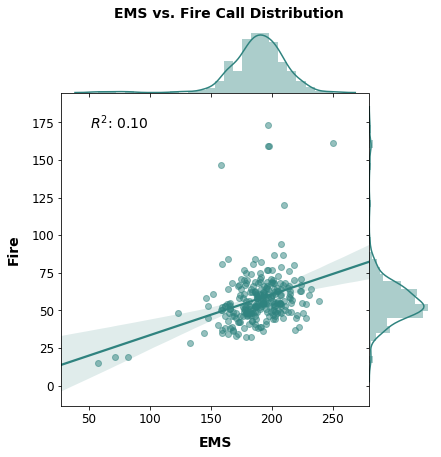

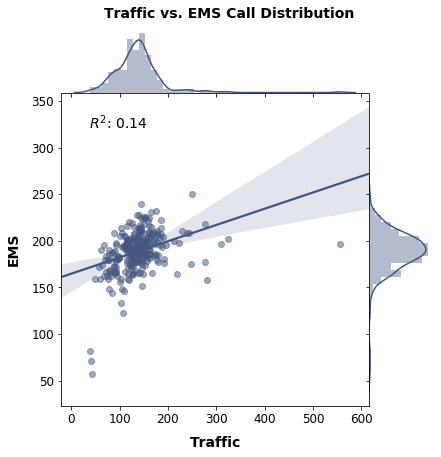

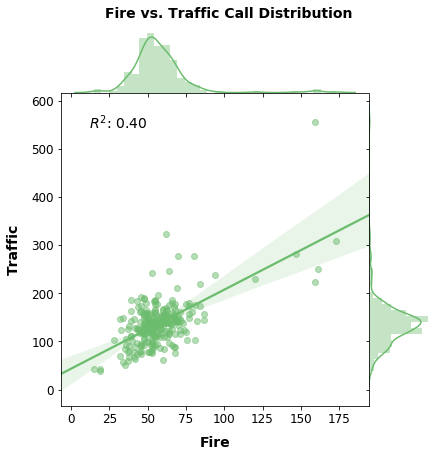

In [68]:
# Create all the department combinations.
dept_combinations = it.combinations(df['Department'].unique(), 2)

# Generate regression plots for each department combination.
for num, comb in enumerate(dept_combinations):
    dept_1, dept_2 = comb
    if num != 1:
        x, y, color = dept_1, dept_2, colors[dept_2]
    else:
        x, y, color = dept_2, dept_1, colors[dept_1]
    
    # Create regression plot.
    g = sns.jointplot(x, y, data=dept_calls_by_date, kind='reg',
                      color=color, space=0, scatter_kws={'alpha':0.5})
    pearsonr = lambda x, y: stats.pearsonr(x, y)[0]**2
    title = "{0} vs. {1} Call Distribution".format(x,y)
    g = g.annotate(pearsonr, template="{stat}: {val:.2f}",
                   stat="$R^2$", loc="upper left", fontsize=14,
                   frameon=False, bbox_to_anchor=(-.075,.975))
    
    # Format figure title and labels.
    g.fig.suptitle(title, y=1.02, weight='bold', fontsize=14)
    format_tick_fontsize(g.ax_joint, tickfont=12)
    format_labels(g.ax_joint, fontsize=14, weight='bold')

The joint distribution plots indicate that among the three department combinations, fire and traffic department call behavior are  the most closely related. To better understand and explore this apparent relationship we need to investigate the reason behind each emergency call.

In [69]:
# Reasons each department was called. 
reasons_list = [df[df['Department']==dept]['Reason'].value_counts()
                for dept in depts]
dept_reasons = dict(zip(depts,reasons_list))

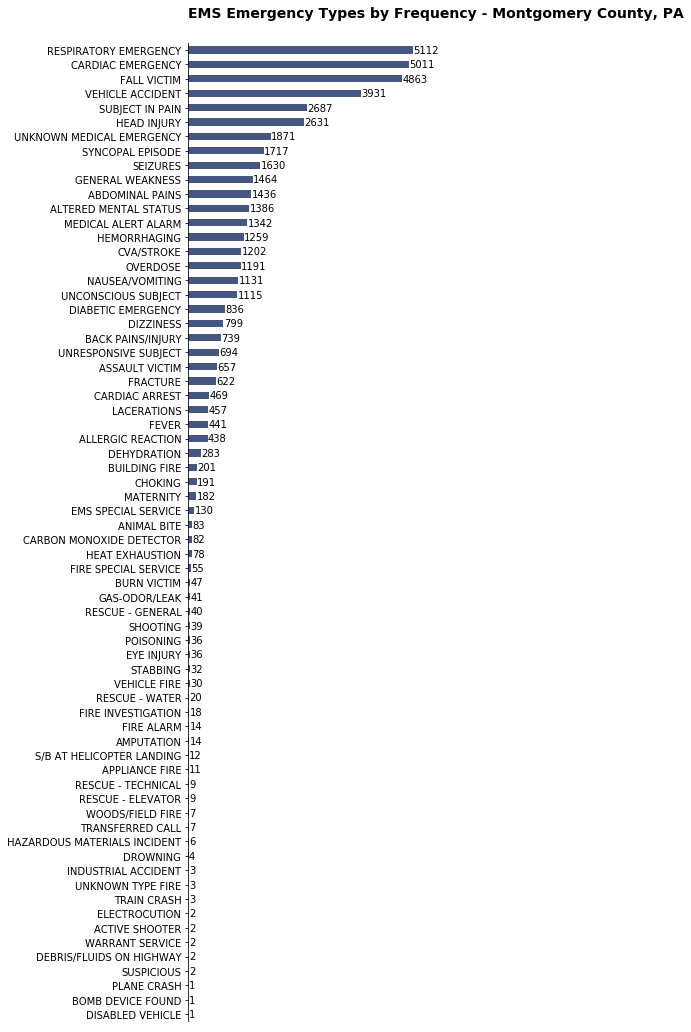

In [70]:
# Create figure and axes.
fig, ax = plt.subplots(figsize=(6,18))

# Plot EMS department information.
dept_reasons['EMS'].plot(kind='barh', color=colors['EMS'], figsize=(6,18),
                         ax=ax)

# Format figure.
title = 'Emergency Types by Frequency'
format_bar_h(ax, 'EMS', dept_reasons, title=title)

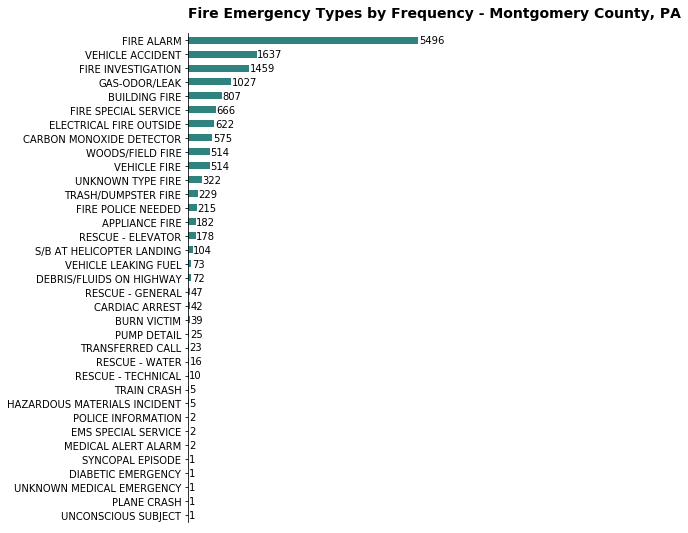

In [71]:
# Create figure and axes.
fig, ax = plt.subplots(figsize=(6,9))

# Plot Fire department information.
dept_reasons['Fire'].plot(kind='barh', color=colors['Fire'], figsize=(6,9),
                          ax=ax)

# Format figure.
title = 'Emergency Types by Frequency'
format_bar_h(ax, 'Fire',dept_reasons, title=title)

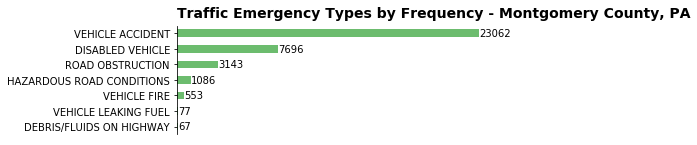

In [72]:
# Create figure and axes.
fig, ax = plt.subplots(figsize=(6,2))

# Plot Traffic department information.
dept_reasons['Traffic'].plot(kind='barh', color=colors['Traffic'],
                             figsize=(6,2), ax=ax)

# Format figure.
title = 'Emergency Types by Frequency'
format_bar_h(ax, 'Traffic', dept_reasons, title=title)

Notice how ***vehicle accidents*** is within the **top 5** emergency situations for which **each of the three departments** was called. 

The **traffic department** received  more than **23,000 calls** due to vehicle accidents, towering beyond any other emergency call to the department.

The county's **EMS** received calls for a large variety of reasons. The two most frequent reasons, cardiac and respiratory emergencies are [in line](https://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm) with national trends. Vehicle accidents were the fourth most common reason EMS was contacted behind fall injuries. 

Fire alarms were the most frequent reason the **fire department** was contacted. Unlike the EMS department, who receives large call volumes for a variety of reasons, the number of calls to the fire department are mostly segregated to a few high frequency emergencies. While the EMS received more calls than the fire department for vehicle accidents, EMS call behavior is temporally damped with respect to variations in any one type of emergency situation. **In essence, it is the fire department's low call volume combined with the frequency of vehicle accidents in Montgomery County that account for the relationship in call behavior between the fire and traffic departments.** 

Lets further explore the temporal behavior of traffic calls.

In [252]:
def plot_formatted_heatmap(df, ax=None, figsize=None, xlblpad=20, ylblpad=-20, 
                           title_y=1.05, cbar_y=1.02, titlefont=18, 
                           axlblfont=16, tickfont=14, ylabel='', xlabel='',
                           ylabel_rot=False, xlabel_rot=False, graph_title='', 
                           cbar_title='# of Calls', linewidth=0.005,
                           linecolor='#111111', cmap='viridis', annot=False,
                           fmt=".0f"):

    # This method creates a formatted heat. 
    #
    # ----------- variables --------------
    # df: 2D Pandas dataframe whose index/columns serve as the labels for the
    #     rows and columns.
    # ax: Matplotlib axes instance.
    # figsize: Figure size for the Matplotlib 'figure' instance. Default value 
    #          used to compute colorbar's aspect is (15,5).
    # xlblpad: Padding between axes and the xlabel.
    # ylblpad: Padding between axes and the ylabel.
    # title_y: Y coordinate location for the figure's title text.
    # cbar_y: Y coordinate location for the figure's colorbar.
    # titlefont: Fontsize for the figure's title text.
    # axlblfont: Fontsize for the axes labels and colorbar title.
    # tickfont: Fontsize for axes and colorbar tickmarks.
    # ylabel: Label text for the y axis.
    # xlabel: Label text for the x axis.
    # ylabel_rot: Rotation of the y axis label.
    # xlabel_rot: Rotation of the x axis label.
    # graph_title: Text for the figure's title.
    # cbar_title: Text for the colorbar's title.
    # linewidth: Line width of the cells in the heatmap.
    # linecolor: Line color of the cells in the heatmap.
    # cmap: Color map for the heatmap.
    # annot: Boolean to decide whether to annotate heatmap values. Change to 
    #        'True' in method call to annotate heatmaps.
    # fmt: Format string used to format annotated values. 
    
    
    # Create figure and/or axes if user did not provide either.
    if ax is None:
        if figsize is None:
            figsize = (15,5)
            fig, ax = plt.subplots(figsize=figsize)
        else:
            fig, ax = plt.subplots(figsize=figsize)
    
    # ----------------------Seaborn Call----------------------------------
    
    # Create a heatmap
    if annot:
        plot = sns.heatmap(df, cmap=cmap, ax=ax, linewidth=linewidth,
                           linecolor=linecolor, cbar_kws={'drawedges': True},
                           annot=annot, fmt=fmt)
    else:
        plot = sns.heatmap(df, cmap=cmap, ax=ax, linewidth=linewidth,
                           linecolor=linecolor, cbar_kws={'drawedges': True})

    # --------------------- Cosmetic Code---------------------------------

    # Display axes' spines.
    for _, spine in ax.spines.items():
        spine.set_visible(True)
   
    # Set and format title and labels.
    ax.set_title(graph_title, loc='center', weight='bold', fontsize=titlefont,
                 y=title_y)
    format_labels(ax, xlabel=xlabel, ylabel=ylabel, xpad=xlblpad, ypad=ylblpad,
                  xrot=xlabel_rot, yrot=ylabel_rot, fontsize=axlblfont, 
                  weight='bold')

    # Format tick font size.
    format_tick_fontsize(ax, tickfont)

    # Obtain colorbar object.
    cbar = ax.collections[0].colorbar

    #  Set colorbar border and remove dividers that appeared due to 
    # 'drawedges = True' in the seaborn heatmap call.
    cbar.outline.set_linewidth(1)
    cbar.dividers.set_color('none')

    # Obtain colorbar tick labels.
    cbar_ticks = [int(num) for num in cbar.locator()]

    # Calculate parameters to adjust colorbar tick labels.
    mx = int(df.max().max())
    mn = int(df.min().min())
    cbar_interval = cbar_ticks[-1]-cbar_ticks[-2]
    top_diff = mx-cbar_ticks[-2]
    min_diff = cbar_ticks[1]-mn
    
    # Adjust color bar tick labels.
    if top_diff < 0.4*cbar_interval:
        del cbar_ticks[-2]
    if min_diff < 0.4*cbar_interval:
        del cbar_ticks[1]
    
    # Set color bar to include minimum and maximum values.
    cbar_ticks[0] = mn
    cbar_ticks[-1] = mx

    # Mark placement of new ticks and add new tick labels. 
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
    cbar.ax.tick_params(labelsize=tickfont)

    # Add a title to the colorbar.
    cbar.ax.set_title(cbar_title, loc='left', y=cbar_y,
                  fontsize=axlblfont)

    # Adjust colorbar width if figsize different from default.
    if figsize != (15,5):
        length, height = figsize
        if length > height:
            cbar.ax.set_aspect(60*height/length)
        elif length < height:
            cbar.ax.set_aspect(60*length/height)
        else:
            cbar.ax.set_aspect(36)
    return plot

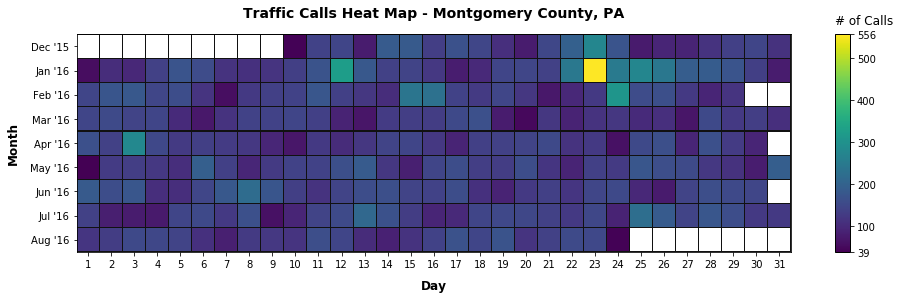

In [253]:
# Generate dataframe whose indeces are months and columns are days of month.
traffic_calls_df = (df[df['Department']=='Traffic'].
                    groupby([pd.Grouper(key='timeStamp', freq='M'),
                             'Day of Month']).
                    count()['e'].unstack(level=-1))

# traffic_calls_df.fillna(0, inplace=True)
# traffic_calls_df = traffic_calls_df.astype(int)
# mask = traffic_calls_df == 0
# traffic_calls_df
# Generate heatmap.
title = 'Traffic Calls Heat Map - Montgomery County, PA'

ax = plot_formatted_heatmap(traffic_calls_df, graph_title=title,
                            ylabel='Month', ylblpad=10, xlabel='Day',
                            xlblpad = 10, tickfont=10, axlblfont=12,
                            figsize=(16,4), titlefont=14,
                            ylabel_rot='vertical')

# Format and set y tick labels.
yticks = []
for index in traffic_calls_df.index:
    datefmt = index.strftime("%b '%y")
    yticks.append(datefmt)
ax.set_yticklabels(yticks)
format_tick_fontsize(ax, tickfont=10)

This heat map reveals the exact date when the traffic department received the maximum number of calls, **January 23rd**.

This is the first search result for *"January 23, 2016 Montgomery County, PA"*.

![2016 Blizzard](https://www.weather.gov/images/phi/events/01232016SnowtotalsObs.png)

The National Weather Service [reported](https://www.weather.gov/phi/01232016wss) that different parts of Montgomery County received **between 16 and 32 inchesof snow.**  *Quite* the snowstorm indeed. The severity of this event is reflected in the large spike in traffic emergency calls as well as the relatively high calls per day following January 23rd.

Lets expand this type of analysis to **visualize call activity by day for each of the three departments**.

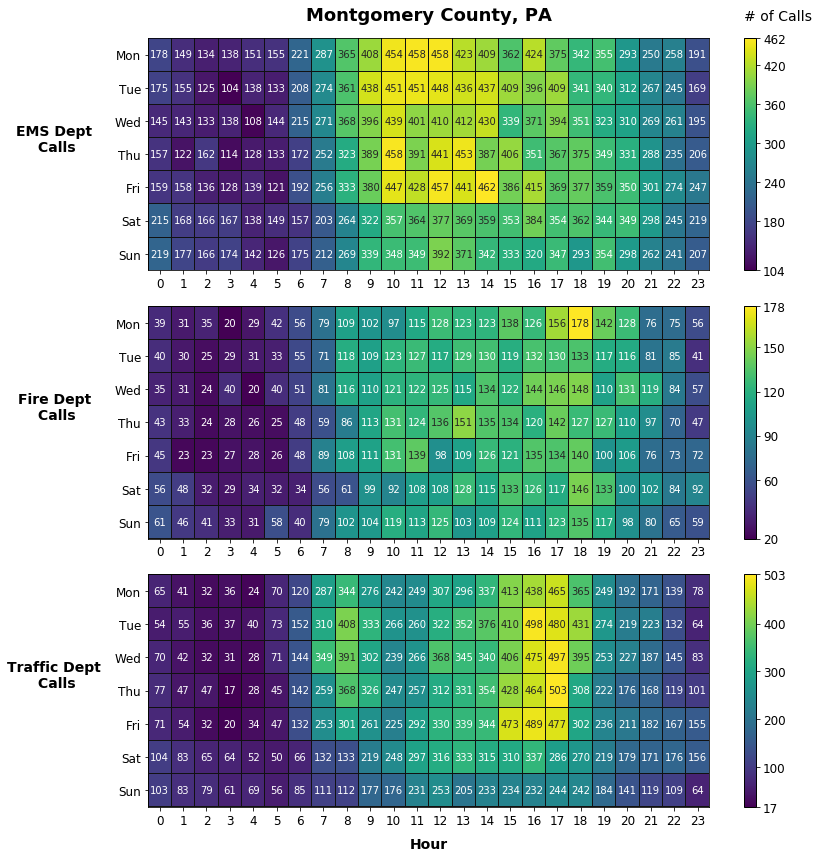

In [254]:
# Create figure and axes instances.
fig, axs = plt.subplots(nrows=3, figsize=(12,12))

# Labels
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Generate three heatmaps, one for each department.
for num, (ax, dept) in enumerate(zip(axs, depts)):
    if num != 0:
        cbar_title = ''
        title = ''
    else:
        cbar_title = '# of Calls'
        title = 'Montgomery County, PA'
    ylabel = '{} Dept\n Calls'.format(dept)
    day_time_df = (df[df['Department']==dept].
                   groupby(['Day of Week', 'Hour']).count()['e'].
                   unstack(level=-1))
    plot_formatted_heatmap(day_time_df, ax=ax, figsize=(12,4),
                           graph_title=title, cbar_title=cbar_title,
                           ylabel=ylabel, xlabel=' ', cbar_y=1.05,
                           ylabel_rot='horizontal', ylblpad=60, axlblfont=14,
                           tickfont=12, annot=True)
    ax.yaxis.set_ticklabels(weekdays, rotation='horizontal')
    if num == 2:
        ax.set_xlabel('Hour', weight='bold', fontsize=14, labelpad=10)
plt.tight_layout()

The **heatmaps** help **reveal** areas of **high** and **low activity.** 

Call activity to the **EMS department** is particularly high between the hours of 9:00 and 14:00 during the weekdays. Calls remain high throughout the afternoon and throughout the weekend. 

The **fire department** call heatmap does not present any particular area of relative high acitivity. As such, the fire department must be equally vigilant at all times of the day. 

The **traffic department** receives a high number of calls during the weekday afternoon hours, namely 16:00-17:00. During the weekends, traffic calls are more evenly distributed throughout the hours of the day.

**The call volume to the traffic department seems to vary the most throughout the day**. As seen before, traffic emergency calls are *predominantly* due to vehicle accidents. **Lets narrow our exploration and visualize how vehicle accident calls vary by week day.**

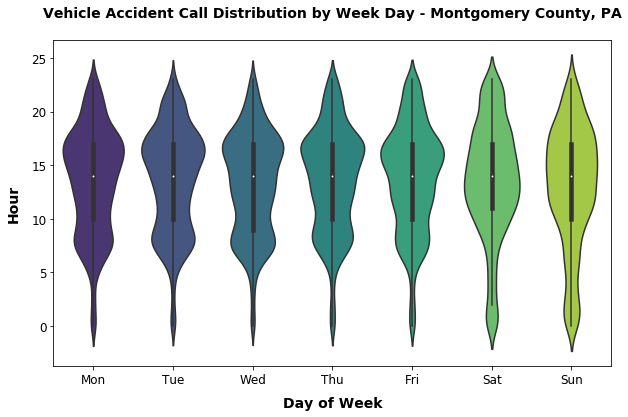

In [76]:
# Create figure and axes instances.
fig, ax = plt.subplots(figsize=(10,6))

# Generate vehicle accident violin plot.
sns.violinplot(x='Day of Week', y='Hour',
               data=df[df['Reason']=='VEHICLE ACCIDENT'], ax=ax,
               palette='viridis');

# Format and set title and labels.
ax.set_title('Vehicle Accident Call Distribution by Week Day'
             + ' - Montgomery County, PA', weight='bold', fontsize=14, y=1.05);
ax.xaxis.set_ticklabels(weekdays);
format_tick_fontsize(ax, tickfont=12) 
format_labels(ax, fontsize=14, weight='bold')

The distribution of vehicle accident calls indicates that for Montgomery County, **accidents are more likely to occur when there are more cars on the road.** 

During weekdays, two distinct humps occur around the time people commute to and from work. After the morning rush hour, accident calls diminish for a short period of time, only to steadily increase and peak around 17:00. Calls dimish as people end their days back at their homes.

During the weekends, people drive during the daytime hours, participating in activities at times that would otherwise be spent at work. Weekends also have more accident calls in the early morning hours, namely midnight to 6 am, than weekdays. This morning distribution is a continuation of the larger call volumes during Friday and Saturday nights.

<br>
<br>
So far, the *call volume by day* and the *reasons why each department was contacted* has been explored. We **haven't explored where** the emergency calls occured. Let us do this now, by **exploring** the ** number of calls by township**  received by each department.

In [77]:
# Create a dictionary of calls by townships by department.
twps_list = [df[df['Department']==dept]['twp'].value_counts()
            for dept in depts]
dept_twps = dict(zip(depts,twps_list))

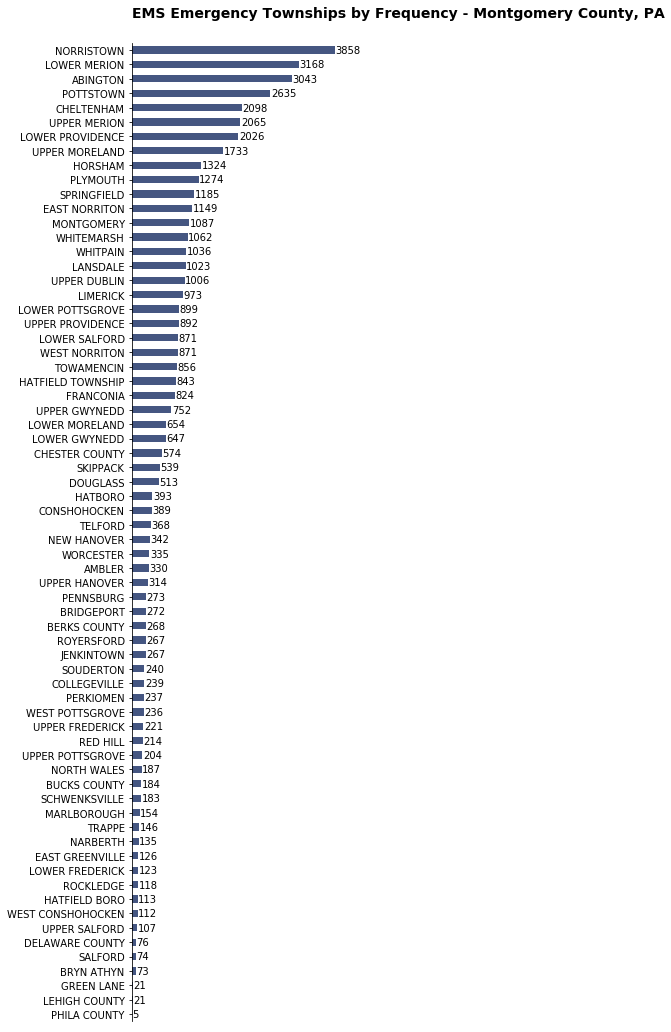

In [78]:
# Create figure and axes.
fig, ax = plt.subplots(figsize=(6,18))

# Plot EMS department information.
dept_twps['EMS'].plot(kind='barh', color=colors['EMS'], figsize=(6,18), ax=ax)

# Format figure.
title = 'Emergency Townships by Frequency'
format_bar_h(ax, 'EMS', dept_twps, title=title)

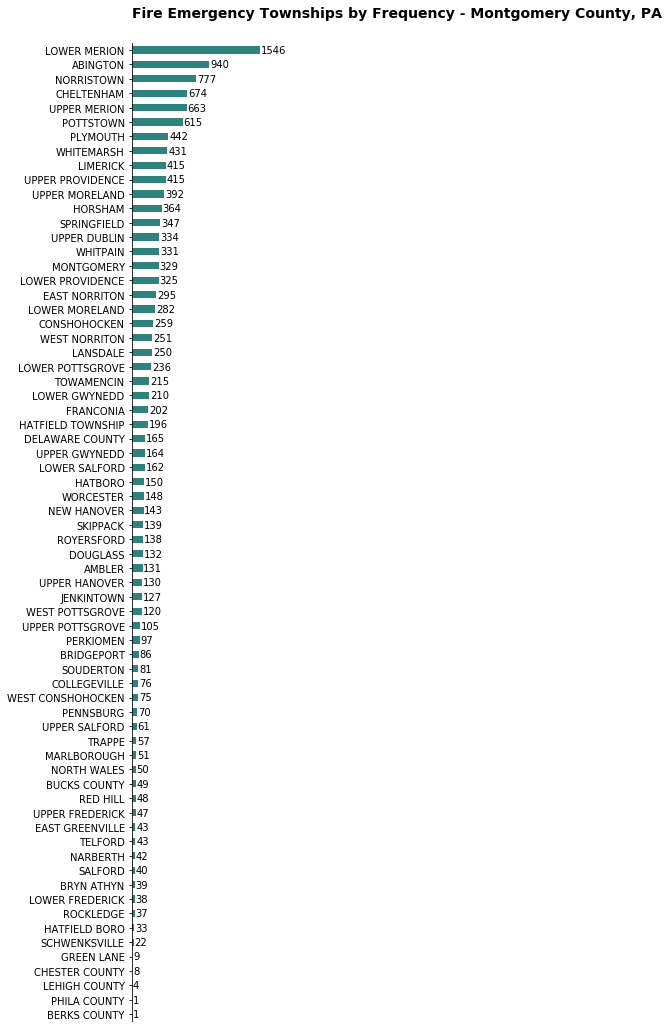

In [79]:
# Create figure and axes.
fig, ax = plt.subplots(figsize=(6,18))

# Plot Fire department information.
dept_twps['Fire'].plot(kind='barh', color=colors['Fire'], figsize=(6,18),
                       ax=ax)

# Format figure.
title = 'Emergency Townships by Frequency'
format_bar_h(ax, 'Fire', dept_twps, title=title)

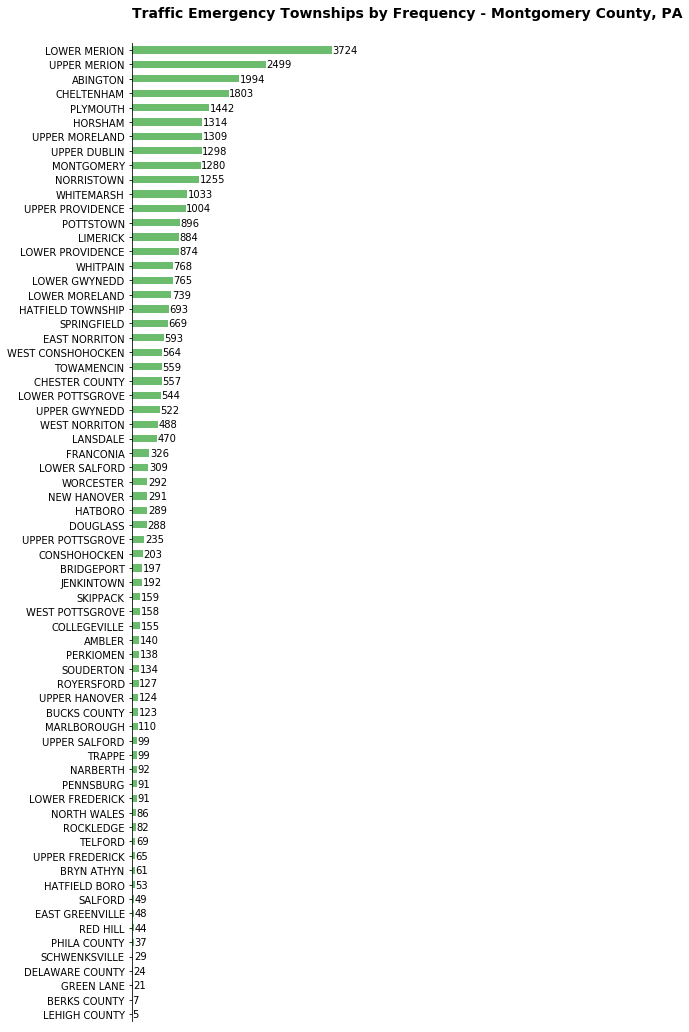

In [80]:
# Create figure and axes.
fig, ax = plt.subplots(figsize=(6,18))

# Plot Traffic department information.
dept_twps['Traffic'].plot(kind='barh', color=colors['Traffic'],
                          figsize=(6,18), ax=ax)

# Format figure.
title = 'Emergency Townships by Frequency'
format_bar_h(ax, 'Traffic', dept_twps, title=title)

The five most populous townships in Montgomery County [are](https://en.wikipedia.org/wiki/Montgomery_County,_Pennsylvania#Demographics):

|Township    |Population|EMS Call Frequency|Fire Call Frequency|Traffic Call Frequency|
|:-----------|---------:|-----------------:|------------------:|---------------------:|
|Lower Merion|57,825    |2nd               |1st                |1st                   |
|Abington    |55,310    |3rd               |2nd                |3rd                   |
|Cheltenham  |36,793    |5th               |4th                |4th                   |
|Norristown  |34,324    |1st               |3rd                |10th                  |
|Upper Merion|28,395    |6th               |5th                |2nd                   |

The relationship between township population and emergency calls could be explored by combining this data set with one such as the 2010 Census. Nevertheless, the available data seems to indicate that Montgomery County's township population size is related to emergency service calls.  

**We can analyze** this data in a more granular fashion, by combining **the township data with the call reasons data.**

In [242]:
def top_r_t(df, dept_twps, dept_reasons, depts, top_percent):
    
    # This method returns a dictionary containing the departments' most
    # frequently contacted townships and the emergency reasons, determined
    # by a cutoff percentage. The title for the graph for each department is
    # also created and returned.
    #
    # ----------- variables --------------
    # df: Pandas dataframe
    # dept_twps: Dictionary whose keys are the department names and values
    #            are a pandas series containing township names and call 
    #            total to keyed department.
    # dept_reasons: Dictionary whose keys are the department names and 
    #               values are a pandas series containing emergency reasons' 
    #               names and call total to keyed department.
    # depts: List of department names
    # top_percent: Percentage, specified as a decimal, that is used to 
    #              filter the department and emergency reasons.
    #              Ex: top_percent = 0.9. Results in bottom ten percent of 
    #              townships and emergency reasons being ommitted from
    #              output dictionary.
    
    # Initialize output variable.
    top_r_t = {}
    
    # Fill output variable.
    for dept in depts:
        # Filter input dictionaries
        reasons_filter = (dept_reasons[dept]>=dept_reasons[dept].
                          max()*(1-top_percent))
        twp_filter = dept_twps[dept]>=dept_twps[dept].max()*(1-top_percent)
        top_r = dept_reasons[dept][reasons_filter].index
        top_t = dept_twps[dept][twp_filter].index
        
        # Conditionally select entries in the data set. 
        data = df[(df['Department']==dept) & (df['Reason'].isin(top_r))
                  & (df['twp'].isin(top_t))]
        
        # Manipulate the data such that all the selected townships are on 
        # the columns and the selected reasons are the rows.
        data = data.groupby(['Reason', 'twp']).count()['e'].unstack(level=-1)
        
        # Format title for heatmap. and modify x/y labels.
        title = ('Calls to {} Department'.format(dept) 
                 + ' - Montgomery County, PA')
        
        # Append data and title
        top_r_t[dept] = {'data': data, 'title': title}
    
    # Return output variable
    return top_r_t

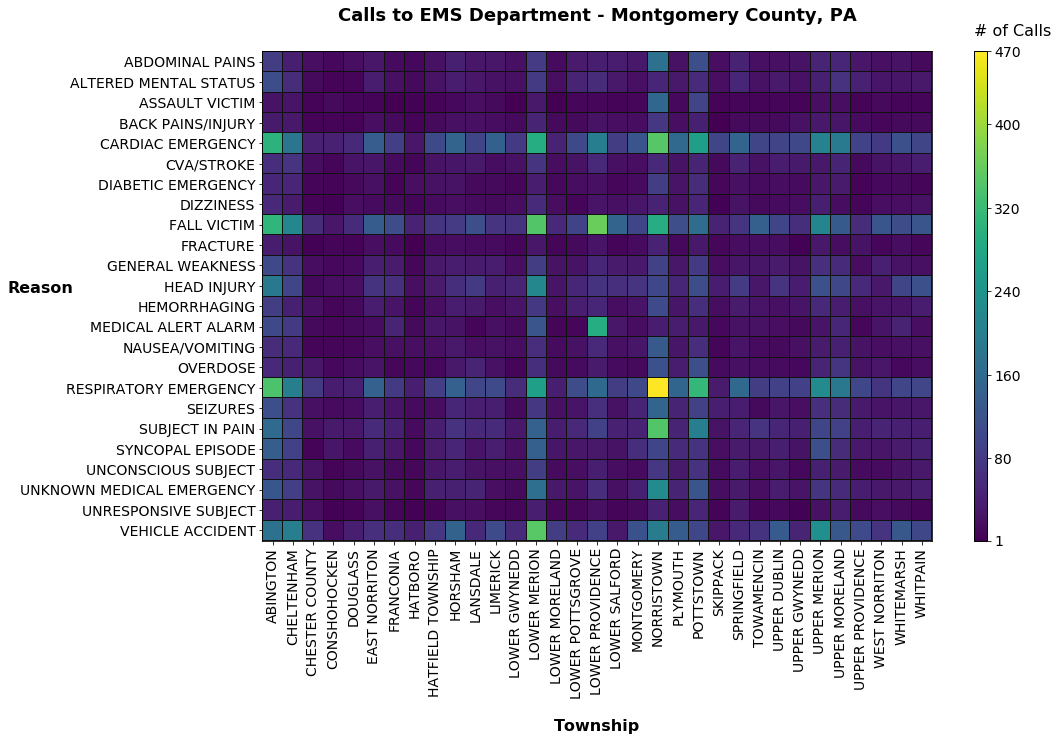

In [267]:
# Combine township and emergency reason data.
top_rt = top_r_t(df, dept_twps, dept_reasons, depts, .9)

# Create figure and axes instance.
fig, ax = plt.subplots(figsize=(15,9))

# Select EMS data and generate heatmap -- add "annot=True" to 
# the arguments of plot_formatted_heatmap to quantify
# specific incidences. 
EMS_data = top_rt['EMS']['data']
EMS_title = top_rt['EMS']['title']
plot = plot_formatted_heatmap(EMS_data, ax=ax, figsize=(15,9),
                              graph_title=EMS_title, ylabel='Reason',
                              xlabel='Township');

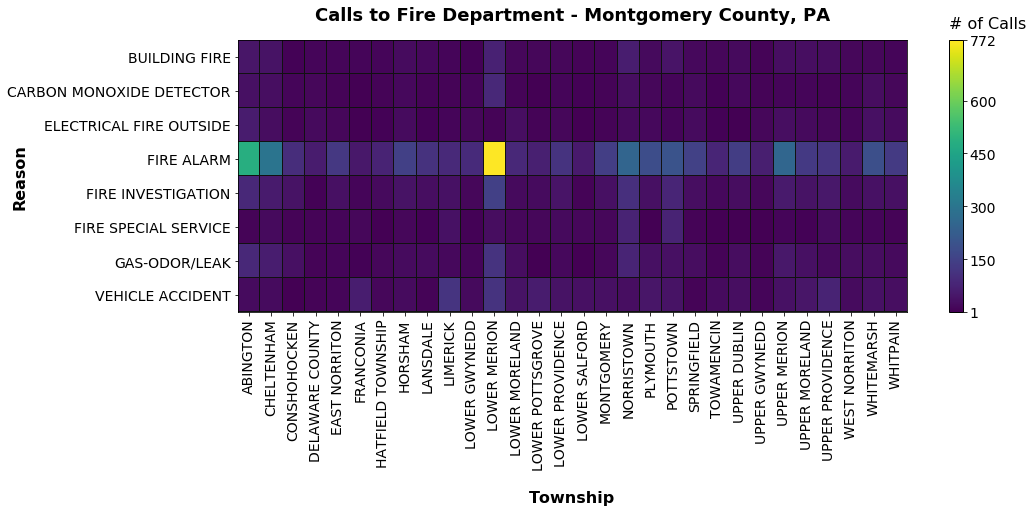

In [256]:
# Select fire dept. data and generate heatmap -- add "annot=True" to 
# the arguments of plot_formatted_heatmap to quantify
# specific incidences. 
Fire_data = top_rt['Fire']['data']
Fire_title = top_rt['Fire']['title']
plot_formatted_heatmap(Fire_data, graph_title=Fire_title, ylabel='Reason',
                              xlabel='Township', ylabel_rot='vertical');

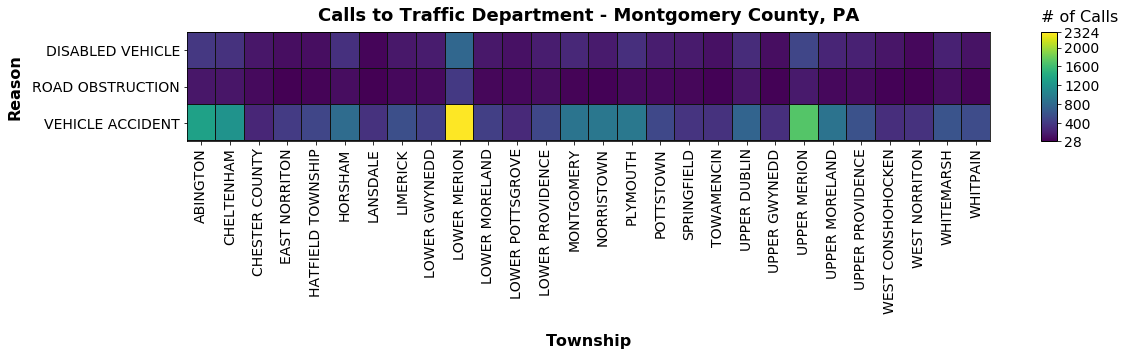

In [257]:
# Create figure and axes instance.
fig, ax = plt.subplots(figsize=(18,2))

# Select traffic data and generate heatmap -- add "annot=True" to 
# the arguments of plot_formatted_heatmap to quantify
# specific incidences. 
Traffic_data = top_rt['Traffic']['data']
Traffic_title = top_rt['Traffic']['title']
plot_formatted_heatmap(Traffic_data, ax=ax, figsize=(18,2),
                       graph_title=Traffic_title, ylblpad=10,
                       cbar_y=1.04, ylabel='Reason', xlabel='Township',
                       ylabel_rot='vertical');

**Light colored rows** indicate that the *corresponding emergency reason* is common among multiple townships. Similarly, **light colored columns** indicate that the *corresponding township* frequently contacted emergency services for various emergency situations.

The heatmaps reveal that Norrigtown had the highest number of respiratory emergencies, while Lower Merion had the highest occurances of fire alarms and vehicle accidents.

## Summary
___

The data visualizations in this project helped to:

1. Elimiate geographically anomalous data.
2. Understand why the similarities in the temporal behavior of fire and traffic emergency calls exist.
3. Rationalize the late January spike in traffic emergency calls.
4. Locate time periods of high emergency call activity by department. 
4. Find temporal patterns in vehicle accident calls.
5. Observe the number and types of emergency calls made by residents of townships in Montgomery County.